<a href="https://colab.research.google.com/github/xuwd11/deepul/blob/master/homeworks/hw1/Homework_1_Autoregressive_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!nvidia-smi

Sat May  2 21:47:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 727 (delta 11), reused 13 (delta 3), pack-reused 697
Receiving objects: 100% (727/727), 119.73 MiB | 30.11 MiB/s, done.
Resolving deltas: 100% (322/322), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16679 sha256=ec525705f3d5f87d949cf0c49cf245ee2169fdf2f50c4287f6eb0124aec75439
  Stored in directory: /tmp/pip-ephem-wheel-cache-fe_d22cr/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [ ]:
from deepul.hw1_helper import *

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


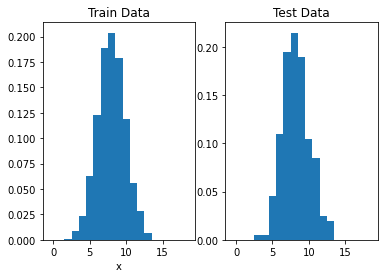

Dataset 2


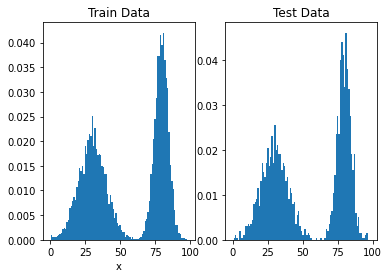

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_epoch(model, train_loader, optimizer, grad_clip=None):
    model.train()
    train_losses = []
    for x in train_loader:
        x = x.to(device)
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train(model, train_loader, test_loader, train_args, print_every=None):
    t0 = time.time()
    num_epochs, lr = train_args["num_epochs"], train_args["lr"]
    grad_clip = train_args.get("grad_clip", None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]

    for epoch in range(num_epochs):
        train_losses.extend(train_epoch(
            model=model, train_loader=train_loader, optimizer=optimizer, grad_clip=grad_clip
        ))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        if print_every and (epoch==num_epochs - 1 or epoch % print_every == 0):
            t = (time.time() - t0) / 60
            print(f"Epoch {epoch}, test loss {test_loss:.4f}, time elapsed {t:.3f} min")
    return train_losses, test_losses

In [ ]:
class Histogram(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
        self.logits = nn.Parameter(torch.zeros(d), requires_grad=True)

    def loss(self, x):
        return F.cross_entropy(self.logits.repeat(x.shape[0], 1), x.long())

    def distribution(self):
        with torch.no_grad():
            dist = F.softmax(self.logits, dim=0)
        return dist.cpu().numpy()

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    
    """ YOUR CODE HERE """
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
    model = Histogram(d).to(device)
    train_losses, test_losses = train(
        model=model, 
        train_loader=train_loader, 
        test_loader=test_loader,
        train_args=dict(num_epochs=20, lr=0.1),
    )
    dist = model.distribution()
    return train_losses, test_losses, dist

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 2.0606


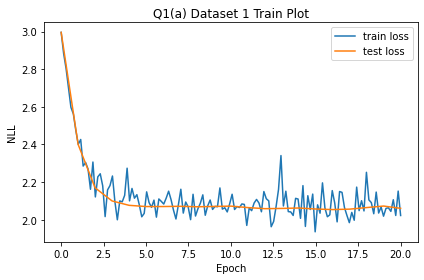

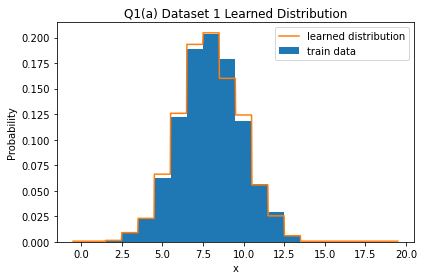

In [ ]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 4.0435


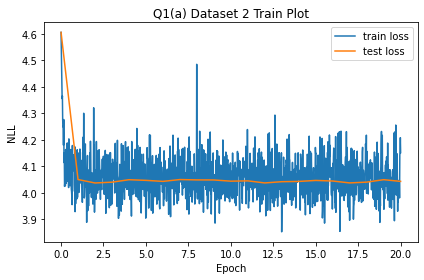

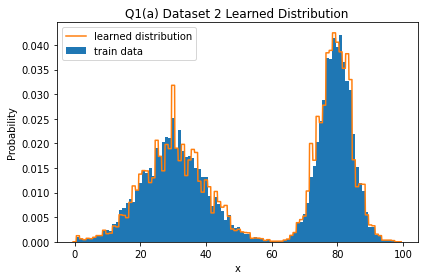

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MixLogistics(nn.Module):
    def __init__(self, d, n_mix=4):
        super().__init__()
        self.d = d
        self.n_mix = n_mix

        self.logits = nn.Parameter(torch.zeros(n_mix), requires_grad=True)
        self.means = nn.Parameter(
            torch.arange(n_mix).float() / (n_mix - 1) * d, requires_grad=True
        )
        self.log_scales = nn.Parameter(torch.randn(n_mix), requires_grad=True)
    
    def forward(self, x):
        d = self.d
        x = x.float().unsqueeze(1).repeat(1, self.n_mix)
        means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0)
        inv_scales = torch.exp(-self.log_scales)
        cdf_plus = torch.sigmoid(inv_scales * (x + 0.5 - means))
        cdf_min = torch.sigmoid(inv_scales * (x - 0.5 - means))
        cdf_delta = cdf_plus - cdf_min
        log_cdf_delta = torch.log(torch.clamp(cdf_delta, min=1e-12))
        log_cdf_left = torch.log(torch.clamp(
            torch.sigmoid(inv_scales * (0.5 - means)), min=1e-12
        ))
        log_cdf_right = torch.log(torch.clamp(
            1 - torch.sigmoid(inv_scales * (d - 1.5 - means)), min=1e-12
        ))
        x_log_probs = torch.where(
            x < 1e-3, log_cdf_left, torch.where(
                x > d - 1 - 1e-3, log_cdf_right, log_cdf_delta
            )
        )
        pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)
        return torch.logsumexp(pi_log_probs + x_log_probs, dim=1)

    def loss(self, x):
        return -torch.mean(self(x))
    
    def distribution(self):
        with torch.no_grad():
            x = torch.arange(self.d).float().to(device)
            dist = self(x).exp()
        return dist.cpu().numpy()

In [ ]:
def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    
    """ YOUR CODE HERE """

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
    model = MixLogistics(d).to(device)
    train_losses, test_losses = train(
        model=model, 
        train_loader=train_loader, 
        test_loader=test_loader,
        train_args=dict(num_epochs=10, lr=0.1),
    )
    dist = model.distribution()
    return train_losses, test_losses, dist

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Final Test Loss: 2.0652


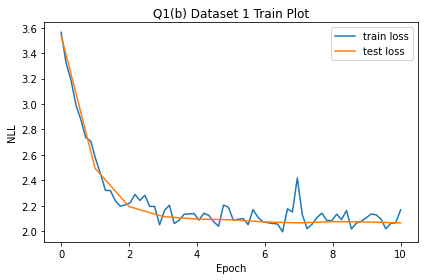

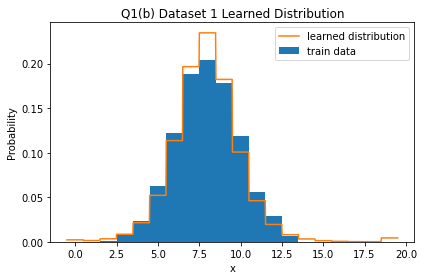

In [ ]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 4.0388


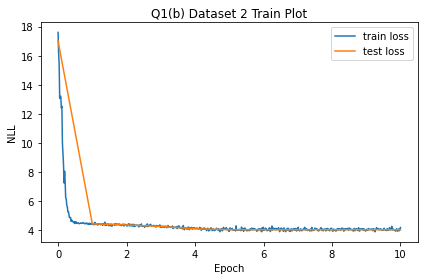

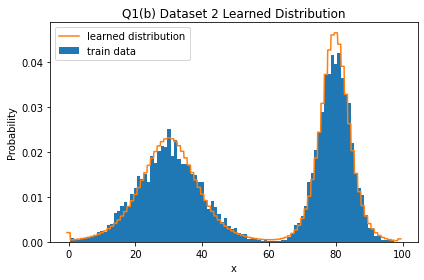

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


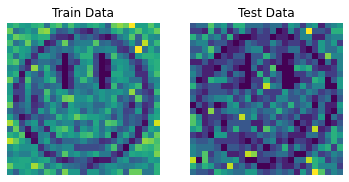

Dataset 2


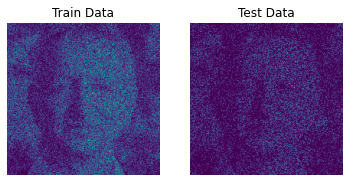

In [ ]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# For debugging purpose

# data_dir = get_data_dir(1)
# n, d = 10000, 25
# true_dist, data = q2_a_sample_data(join(data_dir, 'smiley.jpg'), n, d)
# split = int(0.8 * len(data))
# train_data, test_data = data[:split], data[split:]
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def to_one_hot(labels, d):
    one_hot = torch.FloatTensor(labels.shape[0], d).to(device)
    one_hot.zero_()
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer("mask", torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(
        self, input_shape, d, hidden_sizes=[512, 512, 512], ordering=None, one_hot_input=False
    ):
        super().__init__()
        self.input_shape = input_shape
        self.nin = np.prod(input_shape)
        self.d = d
        self.nout = self.nin * d
        self.hidden_sizes = hidden_sizes
        self.ordering = np.arange(self.nin) if ordering is None else ordering
        self.one_hot_input = one_hot_input

        self.net = []
        hs = [self.nin * d if one_hot_input else self.nin] + self.hidden_sizes + [self.nout]
        for i in range(len(hs) - 1):
            self.net.extend([MaskedLinear(hs[i], hs[i + 1]), nn.ReLU()])
        self.net.pop()
        self.net = nn.Sequential(*self.net)
        
        self.m = {}
        self.update_mask()
    
    def update_mask(self):
        num_hidden = len(self.hidden_sizes)
        self.m[-1] = self.ordering
        for l in range(num_hidden):
            self.m[l] = np.random.randint(
                self.m[l - 1].min(), self.nin - 1, size=self.hidden_sizes[l]
            )
        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(num_hidden)]
        masks.append(self.m[num_hidden - 1][:, None] < self.m[-1][None, :])
        masks[-1] = np.repeat(masks[-1], self.d, axis=1)
        if self.one_hot_input:
            masks[0] = np.repeat(masks[0], self.d, axis=0)
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def forward(self, x):
        batch_size = x.shape[0]
        if self.one_hot_input:
            x = x.long().view(-1)
            x = to_one_hot(x, self.d)
            x = x.view(batch_size, -1)
        else:
            x = x.float()
            x = x.view(batch_size, self.nin)
        logits = self.net(x).view(batch_size, self.nin, self.d)
        return logits.permute(0, 2, 1).view(batch_size, self.d, *self.input_shape)
    
    def loss(self, x):
        return F.cross_entropy(self(x), x.long())
    
    def sample(self, n):
        s = torch.zeros(n, self.nin).to(device)
        with torch.no_grad():
            for i in range(self.nin):
                logits = self(s).view(n, self.d, self.nin)[:, :, self.ordering[i]]
                probs = F.softmax(logits, dim=1)
                s[:, self.ordering[i]] = torch.multinomial(probs, 1).squeeze(-1)
            s = s.view(n, *self.input_shape)
        return s.cpu().numpy()

    def distribution(self):
        assert self.input_shape == (2, )
        x = np.mgrid[0:self.d, 0:self.d].reshape(2, self.d ** 2).T
        with torch.no_grad():
            x = torch.LongTensor(x).to(device)
            log_probs = F.log_softmax(self(x), dim=1)
            dist = torch.gather(log_probs, 1, x.unsqueeze(1)).squeeze(1).sum(dim=1)
        return dist.exp().view(self.d, self.d).cpu().numpy()

In [ ]:
# For debugging purpose

# model = MADE((2, ), d, one_hot_input=True).to(device)
# for x in train_loader:
#     x = x.to(device)
#     print(model(x).shape)
#     print(model.loss(x))
#     print(model.distribution().shape)
#     print(model.sample(10).shape)
#     break

In [ ]:
def q2_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """
    
    """ YOUR CODE HERE """
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
    model = MADE((2, ), d, hidden_sizes=[100, 100], one_hot_input=True).to(device)
    train_losses, test_losses = train(
        model=model, 
        train_loader=train_loader, 
        test_loader=test_loader,
        train_args=dict(num_epochs=20, lr=5e-3),
    )
    dist = model.distribution()
    return train_losses, test_losses, dist

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Final Test Loss: 3.1865


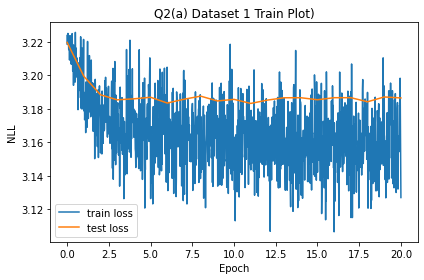

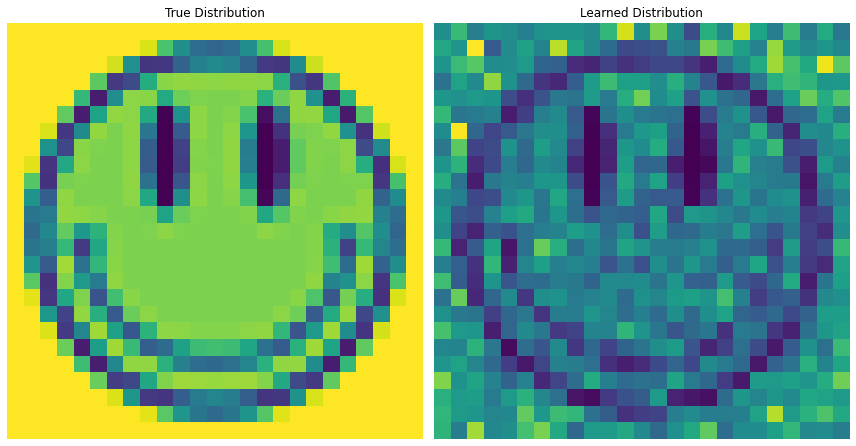

In [ ]:
q2_save_results(1, 'a', q2_a)

Final Test Loss: 5.2928


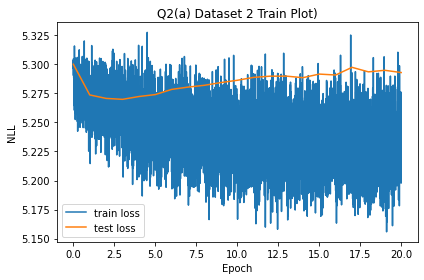

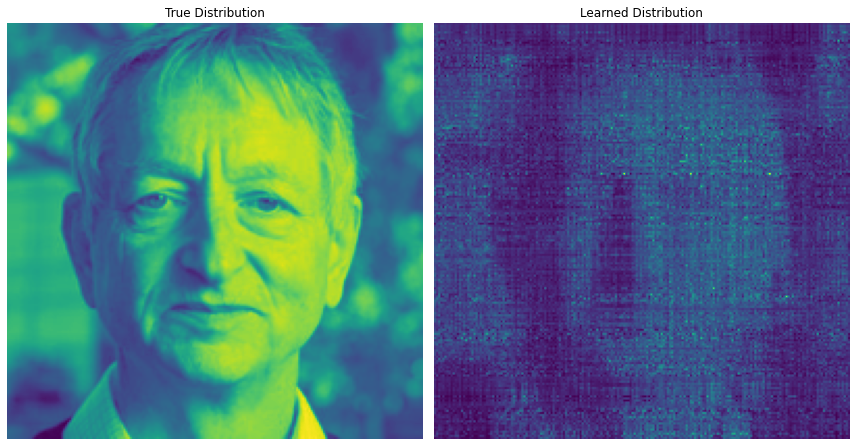

In [ ]:
q2_save_results(2, 'a', q2_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

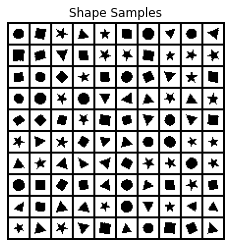

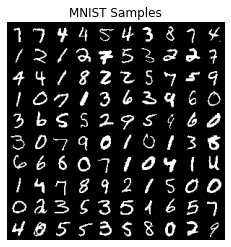

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    
    """ YOUR CODE HERE """
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    H, W = image_shape
    model=MADE((1, H, W), 2, hidden_sizes=[512, 512]).to(device)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
    
    train_losses, test_losses = train(
        model=model, 
        train_loader=train_loader, 
        test_loader=test_loader,
        train_args=dict(num_epochs=20, lr=5e-3),
    )
    samples = model.sample(100)
    samples = np.transpose(samples, (0, 2, 3, 1))
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.0525


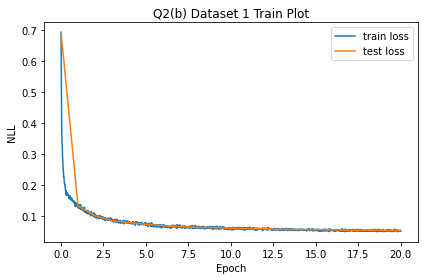

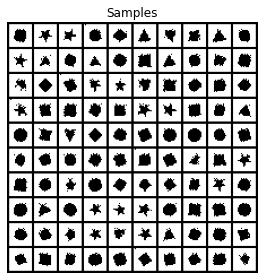

In [ ]:
q2_save_results(1, 'b', q2_b)

Final Test Loss: 0.1181


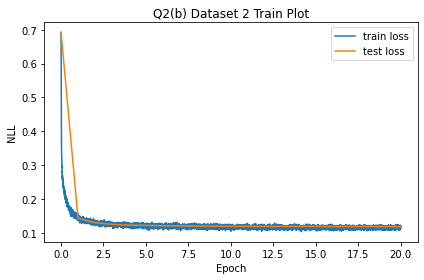

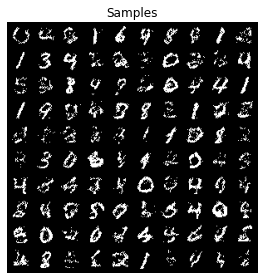

In [ ]:
q2_save_results(2, 'b', q2_b)

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# For debugging purpose

# import numpy as np

# data_dir = get_data_dir(1)
# train_data, test_data = load_pickled_data(join(data_dir, 'shapes.pkl'))
# img_shape = (20, 20)
# train_data = np.transpose(train_data, (0, 3, 1, 2))
# test_data = np.transpose(test_data, (0, 3, 1, 2))
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class MaskConv2d(nn.Conv2d):
    def __init__(
        self, mask_type, *args, conditional_size=None, color_conditioning=False, **kwargs
    ):
        assert mask_type == "A" or mask_type == "B"
        super().__init__(*args, **kwargs)
        self.conditional_size = conditional_size
        self.color_conditioning = color_conditioning
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)
        if self.conditional_size is not None:
            if len(self.conditional_size) == 1:
                self.cond_op = nn.Linear(conditional_size[0], self.out_channels)
            else:
                self.cond_op = nn.Conv2d(
                    conditional_size[0], self.out_channels, kernel_size=3, padding=1
                )

    def create_mask(self, mask_type):
        k = self.kernel_size
        self.mask[:, :, :k[0] // 2] = 1
        self.mask[:, :, k[0] // 2, :k[1] // 2] = 1
        if self.color_conditioning:
            assert self.in_channels % 3 == 0 and self.out_channels % 3 == 0
            one_third_in, one_third_out = self.in_channels // 3, self.out_channels // 3
            if mask_type == "B":
                self.mask[:one_third_out, :one_third_in, k[0] // 2, k[1] // 2] = 1
                self.mask[one_third_out: 2 * one_third_out, :2 * one_third_in, k[0] // 2, k[1]//2] = 1
                self.mask[2 * one_third_out:, :, k[0] // 2, k[1] // 2] = 1
            else:                
                self.mask[one_third_out: 2 * one_third_out, :one_third_in, k[0] // 2, k[1]//2] = 1
                self.mask[2 * one_third_out:, :2 * one_third_in, k[0] // 2, k[1] // 2] = 1
        else:
            if mask_type == "B":
                self.mask[:, :, k[0] // 2, k[1] // 2] = 1

    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        out = F.conv2d(
            input=x, 
            weight=self.mask * self.weight, 
            bias=self.bias, 
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups,
        )
        if self.conditional_size is not None:
            if len(self.conditional_size) == 1:
                out = out + self.cond_op(cond).view(batch_size, -1, 1, 1)
            else:
                out = out + self.cond_op(cond)
        return out

class ResBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, **kwargs):
        super().__init__()
        self.block = nn.ModuleList([
            nn.ReLU(),
            MaskConv2d("B", in_channels, in_channels // 2, 1, **kwargs),
            nn.ReLU(),
            MaskConv2d(
                "B", in_channels // 2, in_channels // 2, kernel_size, padding=kernel_size // 2, **kwargs
            ),
            nn.ReLU(),
            MaskConv2d("B", in_channels // 2, in_channels, 1, **kwargs),
        ])

    def forward(self, x, cond=None):
        out = x
        for layer in self.block:
            if isinstance(layer, MaskConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return out + x

class LayerNorm(nn.LayerNorm):
    def __init__(self, color_conditioning, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.color_conditioning = color_conditioning
    
    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        if self.color_conditioning:
            x = x.view(*(x_shape[:-1] + (3, -1)))
        x = super().forward(x)
        if self.color_conditioning:
            x = x.view(*x_shape)
        return x.permute(0, 3, 1, 2).contiguous()

class PixelCNN(nn.Module):
    def __init__(
        self, input_shape, n_colors, n_filters=64, kernel_size=7, n_layers=5,
        conditional_size=None, use_resblock=False, color_conditioning=False
    ):
        super().__init__()
        assert n_layers >= 2
        n_channels = input_shape[0]

        kwargs = dict(
            conditional_size=conditional_size, color_conditioning=color_conditioning
        )
        
        if use_resblock:
            block_init = lambda: ResBlock(n_filters, kernel_size, **kwargs)
        else:
            block_init = lambda: MaskConv2d(
                "B", n_filters, n_filters, kernel_size=kernel_size, padding=kernel_size //2 , **kwargs
            )

        model = nn.ModuleList([
            MaskConv2d(
                "A", n_channels, n_filters, kernel_size=kernel_size, padding=kernel_size //2 , **kwargs
            )
        ])

        for _ in range(n_layers):
            if color_conditioning:
                model.append(LayerNorm(color_conditioning, n_filters // 3))
            else:
                model.append(LayerNorm(color_conditioning, n_filters))
            model.extend([nn.ReLU(), block_init()])
        model.extend([nn.ReLU(), MaskConv2d("B", n_filters, n_filters, 1, **kwargs)])
        model.extend([nn.ReLU(), MaskConv2d("B", n_filters, n_colors * n_channels, 1, **kwargs)])
        
        if conditional_size:
            if len(conditional_size) == 1:
                self.cond_op = lambda x: x
            else:
                self.cond_op = nn.Sequential(
                    nn.Conv2d(1, 64, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, 3, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, 3, padding=1),
                    nn.ReLU(),
                )

        self.net = model
        self.input_shape = input_shape
        self.n_colors = n_colors
        self.n_channels = n_channels
        self.color_conditioning = color_conditioning
        self.conditional_size = conditional_size

    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        out = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        if self.conditional_size:
            cond = self.cond_op(cond)
        for layer in self.net:
            if isinstance(layer, MaskConv2d) or isinstance(layer, ResBlock):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        
        if self.color_conditioning:
            return out.view(
                batch_size, self.n_channels, self.n_colors, *self.input_shape[1:]
            ).permute(0, 2, 1, 3, 4)
        else:
            return out.view(batch_size, self.n_colors, *self.input_shape)

    def loss(self, x, cond=None):
        return F.cross_entropy(self(x, cond=cond), x.long())

    def sample(self, n, cond=None, device=device):
        samples = torch.zeros(n, *self.input_shape).to(device)
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.n_channels):
                        logits = self(samples, cond=cond)[:, :, k, r, c]
                        probs = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

# For debugging purpose

# model = nn.Sequential(
#     MaskConv2d("A", 1, 15, kernel_size=7).to(device),
#     ResBlock(15, 7),
#     LayerNorm(False, 15)
# ).to(device)
# model = PixelCNN((1, 20, 20), 2).to(device)

# for x in train_loader:
#     print(x.shape)
#     print(model.loss(x.to(device)))
#     break

In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    
    """ YOUR CODE HERE """

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

    H, W = image_shape
    model = PixelCNN((1, H, W), 2, n_layers=5).to(device)

    train_losses, test_losses = train(model, train_loader, test_loader, dict(num_epochs=10, lr=1e-3), print_every=1)
    samples = model.sample(100)

    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



Epoch 0, test loss 0.1464, time elapsed 0.139 min
Epoch 1, test loss 0.1045, time elapsed 0.264 min
Epoch 2, test loss 0.0737, time elapsed 0.389 min
Epoch 3, test loss 0.0561, time elapsed 0.515 min
Epoch 4, test loss 0.0484, time elapsed 0.640 min
Epoch 5, test loss 0.0459, time elapsed 0.766 min
Epoch 6, test loss 0.0431, time elapsed 0.892 min
Epoch 7, test loss 0.0410, time elapsed 1.017 min
Epoch 8, test loss 0.0405, time elapsed 1.143 min
Epoch 9, test loss 0.0395, time elapsed 1.268 min
Final Test Loss: 0.0395


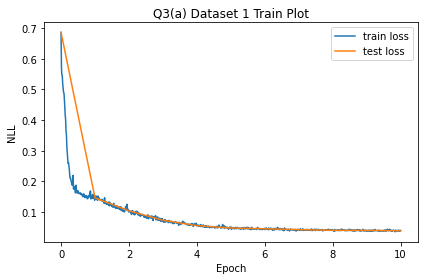

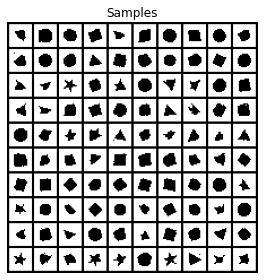

In [ ]:
q3a_save_results(1, q3_a)

Epoch 0, test loss 0.0883, time elapsed 1.801 min
Epoch 1, test loss 0.0813, time elapsed 3.505 min
Epoch 2, test loss 0.0784, time elapsed 5.209 min
Epoch 3, test loss 0.0780, time elapsed 6.913 min
Epoch 4, test loss 0.0777, time elapsed 8.619 min
Epoch 5, test loss 0.0765, time elapsed 10.325 min
Epoch 6, test loss 0.0765, time elapsed 12.028 min
Epoch 7, test loss 0.0758, time elapsed 13.731 min
Epoch 8, test loss 0.0754, time elapsed 15.434 min
Epoch 9, test loss 0.0761, time elapsed 17.135 min
Final Test Loss: 0.0761


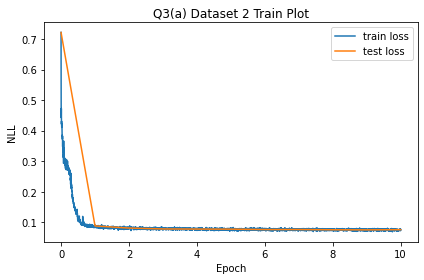

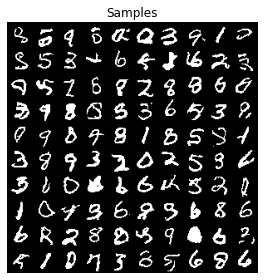

In [ ]:
q3a_save_results(2, q3_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

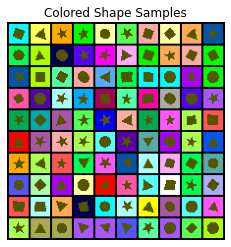

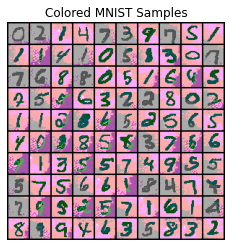

In [ ]:
visualize_q3b_data(1)
visualize_q3b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    
    """ YOUR CODE HERE """
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

    H, W, C = image_shape
    model = PixelCNN((C, H, W), n_colors=4, n_filters=120, n_layers=8, use_resblock=True).to(device)

    train_losses, test_losses = train(
        model, train_loader, test_loader, dict(num_epochs=15, lr=1e-3, grad_clip=1), print_every=1
    )
    samples = model.sample(100)

    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results



Epoch 0, test loss 0.1351, time elapsed 0.358 min
Epoch 1, test loss 0.0863, time elapsed 0.677 min
Epoch 2, test loss 0.0743, time elapsed 0.998 min
Epoch 3, test loss 0.0676, time elapsed 1.318 min
Epoch 4, test loss 0.0671, time elapsed 1.638 min
Epoch 5, test loss 0.0572, time elapsed 1.959 min
Epoch 6, test loss 0.0566, time elapsed 2.280 min
Epoch 7, test loss 0.0515, time elapsed 2.600 min
Epoch 8, test loss 0.0496, time elapsed 2.920 min
Epoch 9, test loss 0.0468, time elapsed 3.241 min
Epoch 10, test loss 0.0469, time elapsed 3.561 min
Epoch 11, test loss 0.0489, time elapsed 3.881 min
Epoch 12, test loss 0.0442, time elapsed 4.202 min
Epoch 13, test loss 0.0436, time elapsed 4.522 min
Epoch 14, test loss 0.0434, time elapsed 4.843 min
Final Test Loss: 0.0434


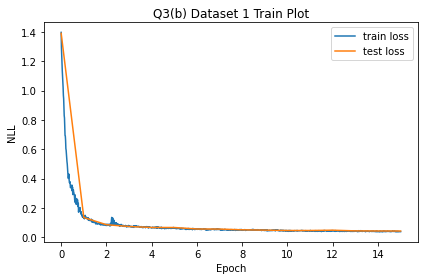

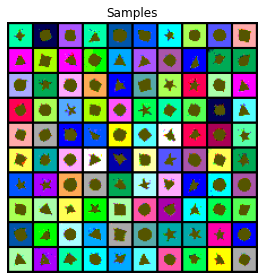

In [ ]:
q3bc_save_results(1, 'b', q3_b)

Epoch 0, test loss 0.1620, time elapsed 4.139 min
Epoch 1, test loss 0.1104, time elapsed 8.056 min
Epoch 2, test loss 0.0988, time elapsed 11.975 min
Epoch 3, test loss 0.0941, time elapsed 15.893 min
Epoch 4, test loss 0.0908, time elapsed 19.813 min
Epoch 5, test loss 0.0891, time elapsed 23.732 min
Epoch 6, test loss 0.0863, time elapsed 27.649 min
Epoch 7, test loss 0.0870, time elapsed 31.566 min
Epoch 8, test loss 0.0844, time elapsed 35.489 min
Epoch 9, test loss 0.0829, time elapsed 39.408 min
Epoch 10, test loss 0.0825, time elapsed 43.328 min
Epoch 11, test loss 0.1598, time elapsed 47.245 min
Epoch 12, test loss 0.0822, time elapsed 51.161 min
Epoch 13, test loss 0.0821, time elapsed 55.079 min
Epoch 14, test loss 0.0805, time elapsed 58.992 min
Final Test Loss: 0.0805


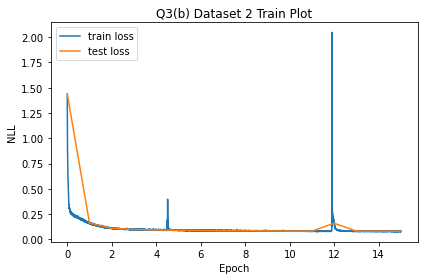

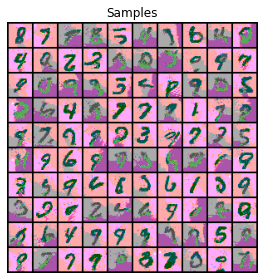

In [ ]:
q3bc_save_results(2, 'b', q3_b)

## Part (c) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    
    """ YOUR CODE HERE """
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

    H, W, C = image_shape
    model = PixelCNN(
        (C, H, W), n_colors=4, n_filters=120, n_layers=8, use_resblock=True, color_conditioning=True
    ).to(device)

    train_losses, test_losses = train(
        model, train_loader, test_loader, dict(num_epochs=15, lr=1e-3, grad_clip=1), print_every=1
    )
    samples = model.sample(100)

    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



Epoch 0, test loss 0.2222, time elapsed 0.475 min
Epoch 1, test loss 0.1042, time elapsed 0.899 min
Epoch 2, test loss 0.0767, time elapsed 1.323 min
Epoch 3, test loss 0.0581, time elapsed 1.747 min
Epoch 4, test loss 0.0453, time elapsed 2.171 min
Epoch 5, test loss 0.0353, time elapsed 2.595 min
Epoch 6, test loss 0.0310, time elapsed 3.020 min
Epoch 7, test loss 0.0288, time elapsed 3.444 min
Epoch 8, test loss 0.0279, time elapsed 3.868 min
Epoch 9, test loss 0.0514, time elapsed 4.292 min
Epoch 10, test loss 0.0278, time elapsed 4.717 min
Epoch 11, test loss 0.0259, time elapsed 5.141 min
Epoch 12, test loss 0.0250, time elapsed 5.565 min
Epoch 13, test loss 0.0255, time elapsed 5.989 min
Epoch 14, test loss 0.0234, time elapsed 6.413 min
Final Test Loss: 0.0234


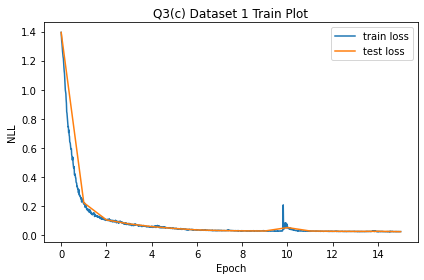

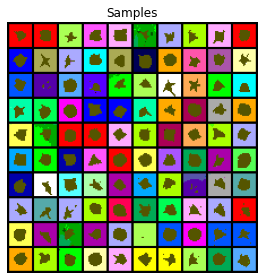

In [ ]:
q3bc_save_results(1, 'c', q3_c)

Epoch 0, test loss 0.1212, time elapsed 5.253 min
Epoch 1, test loss 0.0594, time elapsed 10.239 min
Epoch 2, test loss 0.0455, time elapsed 15.225 min
Epoch 3, test loss 0.0409, time elapsed 20.210 min
Epoch 4, test loss 0.0385, time elapsed 25.198 min
Epoch 5, test loss 0.0374, time elapsed 30.184 min
Epoch 6, test loss 0.0368, time elapsed 35.173 min
Epoch 7, test loss 0.0358, time elapsed 40.159 min
Epoch 8, test loss 0.0351, time elapsed 45.147 min
Epoch 9, test loss 0.0422, time elapsed 50.134 min
Epoch 10, test loss 0.0348, time elapsed 55.120 min
Epoch 11, test loss 0.0338, time elapsed 60.107 min
Epoch 12, test loss 0.0328, time elapsed 65.095 min
Epoch 13, test loss 0.0324, time elapsed 70.086 min
Epoch 14, test loss 0.0322, time elapsed 75.077 min
Final Test Loss: 0.0322


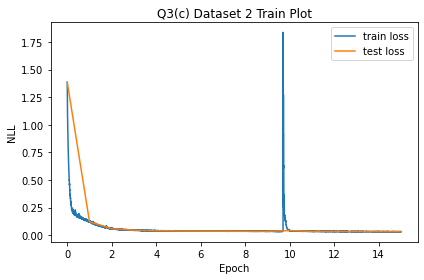

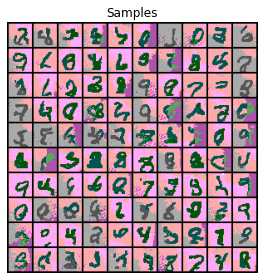

In [ ]:
q3bc_save_results(2, 'c', q3_c)

## Part (d) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

def train_epoch_cond(model, train_loader, optimizer, grad_clip=None):
    model.train()
    train_losses = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        loss = model.loss(x, cond=y)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses

def eval_loss_cond(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            loss = model.loss(x, cond=y)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_cond(model, train_loader, test_loader, train_args, print_every=None):
    t0 = time.time()
    num_epochs, lr = train_args["num_epochs"], train_args["lr"]
    grad_clip = train_args.get("grad_clip", None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss_cond(model, test_loader)]

    for epoch in range(num_epochs):
        train_losses.extend(train_epoch_cond(
            model=model, train_loader=train_loader, optimizer=optimizer, grad_clip=grad_clip
        ))
        test_loss = eval_loss_cond(model, test_loader)
        test_losses.append(test_loss)
        if print_every and (epoch==num_epochs - 1 or epoch % print_every == 0):
            t = (time.time() - t0) / 60
            print(f"Epoch {epoch}, test loss {test_loss:.4f}, time elapsed {t:.3f} min")
    return train_losses, test_losses

In [ ]:
def preprocess_dset(data, labels, n_classes):
    data = np.transpose(data, (0, 3, 1, 2))
    labels_oh = np.zeros((len(labels), n_classes), dtype=np.float32)
    labels_oh[np.arange(len(labels)), labels] = 1
    return data, labels_oh

In [ ]:
def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
    """
    train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
    train_labels: A (n_train,) numpy array of class labels
    test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
    test_labels: A (n_test,) numpy array of class labels
    image_shape: (H, W), height and width
    n_classes: number of classes (4 or 10)
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
        where an even number of images of each class are sampled with 100 total
    """
    
    """ YOUR CODE HERE """
    train_data, train_labels_oh = preprocess_dset(train_data, train_labels, n_classes)
    test_data, test_labels_oh = preprocess_dset(test_data, test_labels, n_classes)

    train_loader = torch.utils.data.DataLoader(
        SimpleDataset(train_data, train_labels_oh), batch_size=128, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        SimpleDataset(test_data, test_labels_oh), batch_size=128, shuffle=False
    )

    H, W = image_shape
    model = PixelCNN((1, H, W), 2, conditional_size=(n_classes,)).to(device)

    train_losses, test_losses = train_cond(
        model, train_loader, test_loader, dict(num_epochs=10, lr=1e-3), print_every=1
    )

    cond = torch.arange(n_classes).unsqueeze(1).repeat(1, 100 // n_classes).view(-1).long()
    one_hot = torch.zeros(cond.shape[0], n_classes, dtype=torch.float)
    one_hot[torch.arange(cond.shape[0]), cond] = 1
    one_hot = one_hot.to(device)

    samples = model.sample(100, cond=one_hot)

    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_d`, execute the cells below to visualize and save your results



Epoch 0, test loss 0.1132, time elapsed 0.147 min
Epoch 1, test loss 0.0908, time elapsed 0.279 min
Epoch 2, test loss 0.0739, time elapsed 0.411 min
Epoch 3, test loss 0.0596, time elapsed 0.543 min
Epoch 4, test loss 0.0528, time elapsed 0.675 min
Epoch 5, test loss 0.0448, time elapsed 0.808 min
Epoch 6, test loss 0.0409, time elapsed 0.940 min
Epoch 7, test loss 0.0375, time elapsed 1.072 min
Epoch 8, test loss 0.0384, time elapsed 1.204 min
Epoch 9, test loss 0.0382, time elapsed 1.337 min
Final Test Loss: 0.0382


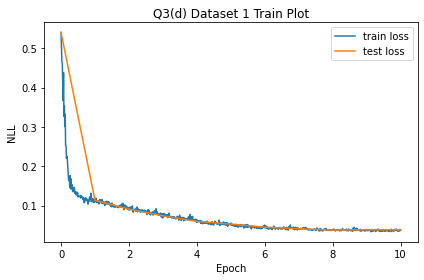

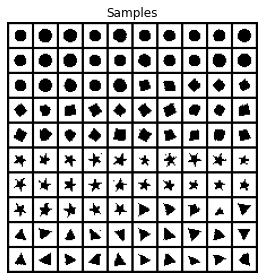

In [ ]:
q3d_save_results(1, q3_d)

Epoch 0, test loss 0.0808, time elapsed 1.856 min
Epoch 1, test loss 0.0753, time elapsed 3.607 min
Epoch 2, test loss 0.0744, time elapsed 5.360 min
Epoch 3, test loss 0.0732, time elapsed 7.114 min
Epoch 4, test loss 0.0727, time elapsed 8.867 min
Epoch 5, test loss 0.0723, time elapsed 10.620 min
Epoch 6, test loss 0.0726, time elapsed 12.374 min
Epoch 7, test loss 0.0725, time elapsed 14.126 min
Epoch 8, test loss 0.0712, time elapsed 15.879 min
Epoch 9, test loss 0.0719, time elapsed 17.631 min
Final Test Loss: 0.0719


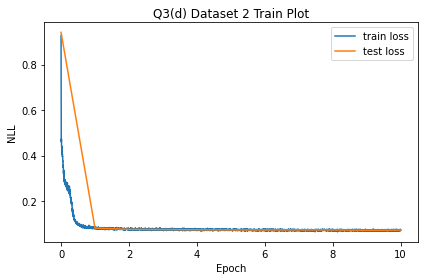

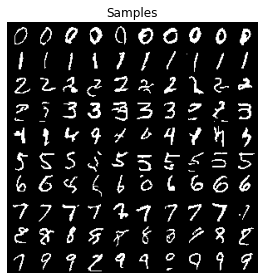

In [ ]:
q3d_save_results(2, q3_d)

# Question 4: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# For debugging purpose

# import numpy as np

# data_dir = get_data_dir(1)
# train_data, test_data = load_pickled_data(join(data_dir, 'mnist_colored.pkl'))
# image_shape = (28, 28, 3)
# H, W, C = image_shape
# train_data = np.transpose(train_data, (0, 3, 1, 2))
# test_data = np.transpose(test_data, (0, 3, 1, 2))
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
class StackLayerNorm(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.h_layer_norm = LayerNorm(False, n_filters)
        self.v_layer_norm = LayerNorm(False, n_filters)

    def forward(self, x):
        vx, hx = x.chunk(2, dim=1)
        vx, hx = self.v_layer_norm(vx), self.h_layer_norm(hx)
        return torch.cat((vx, hx), dim=1)

class GatedConv2d(nn.Module):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=7, padding=3):
        assert mask_type == "A" or mask_type == "B"
        super().__init__()

        k = kernel_size
        self.vertical = nn.Conv2d(
            in_channels, 2 * out_channels, kernel_size=k, padding=padding, bias=False
        )
        self.horizontal = nn.Conv2d(
            in_channels, 2 * out_channels, kernel_size=(1, k), padding=(0, padding), bias=False
        )
        self.vtoh = nn.Conv2d(2 * out_channels, 2 * out_channels, kernel_size=1, bias=False)
        self.htoh = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False)

        self.register_buffer("vmask", torch.zeros_like(self.vertical.weight))
        self.register_buffer("hmask", torch.zeros_like(self.horizontal.weight))

        self.vmask[:, :, :k // 2 + 1, :] = 1
        self.hmask[:, :, :, :k // 2] = 1
        if mask_type == "B":
            self.hmask[:, :, :, k // 2] = 1
    
    def down_shift(self, x):
        return F.pad(x[:, :, :-1, :], (0, 0, 1, 0))

    def forward(self, x):
        vx, hx = x.chunk(2, dim=1)

        self.vertical.weight.data *= self.vmask
        self.horizontal.weight.data *= self.hmask

        vx = self.vertical(vx)
        hx_res = self.horizontal(hx) + self.vtoh(self.down_shift(vx))

        # gates
        vx1, vx2 = vx.chunk(2, dim=1)
        vx = torch.tanh(vx1) * torch.sigmoid(vx2)

        hx1, hx2 = hx_res.chunk(2, dim=1)
        hx_res = self.htoh(torch.tanh(hx1) * torch.sigmoid(hx2))
        hx = hx + hx_res

        return torch.cat((vx, hx), dim=1)    

class GatedPixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors, n_filters=64, kernel_size=7, n_layers=8):
        super().__init__()
        self.n_channels = input_shape[0]
        self.n_colors = n_colors
        self.input_shape = input_shape
        k = kernel_size

        self.in_conv = MaskConv2d("A", self.n_channels, n_filters, kernel_size=k, padding=k // 2)
        model = []
        for _ in range(n_layers - 2):
            model.extend([nn.ReLU(), GatedConv2d("B", n_filters, n_filters, k, padding=k // 2)])
            model.append(StackLayerNorm(n_filters))
        self.net = nn.Sequential(*model)
        self.out_conv = MaskConv2d("B", n_filters, n_colors * self.n_channels, k, padding=k // 2)  

    def forward(self, x):
        batch_size = x.shape[0]
        out = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        out = self.in_conv(out)
        out = self.net(torch.cat((out, out), dim=1)).chunk(2, dim=1)[1]
        out = self.out_conv(out)
        return out.view(
            batch_size, self.n_channels, self.n_colors, *self.input_shape[1:]
        ).permute(0, 2, 1, 3, 4)  

    def loss(self, x):
        return F.cross_entropy(self(x), x.long())

    def sample(self, n, cond=None, device=device):
        samples = torch.zeros(n, *self.input_shape).to(device)
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.n_channels):
                        logits = self(samples)[:, :, k, r, c]
                        probs = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()


# For debugging purpose

# model = nn.Sequential(
#     MaskConv2d("A", 3, 20, kernel_size=7, padding=3).to(device),
#     GatedConv2d("B", 10, 10, kernel_size=7, padding=3),
#     StackLayerNorm(10),
# ).to(device)
# model = GatedPixelCNN((C, H, W), 4).to(device)

# for x in train_loader:
#     print(x.shape)
#     print(model.loss(x.float().to(device)).item())
#     break

In [ ]:
def q4_a(train_data, test_data, image_shape):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
    """
    """ YOUR CODE HERE """
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

    H, W, C = image_shape
    model = GatedPixelCNN((C, H, W), n_colors=4, n_filters=64, kernel_size=7, n_layers=8).to(device)

    train_losses, test_losses = train(
        model, train_loader, test_loader, dict(num_epochs=15, lr=1e-3, grad_clip=1), print_every=1
    )
    samples = model.sample(100)

    return train_losses, test_losses, samples

### Results

Once you've implemented `q4_a`, execute the cells below to visualize and save your results



Epoch 0, test loss 0.1566, time elapsed 10.897 min
Epoch 1, test loss 0.0950, time elapsed 21.380 min
Epoch 2, test loss 0.0870, time elapsed 31.853 min
Epoch 3, test loss 0.0842, time elapsed 42.318 min
Epoch 4, test loss 0.0816, time elapsed 52.793 min
Epoch 5, test loss 0.0797, time elapsed 63.275 min
Epoch 6, test loss 0.0790, time elapsed 73.759 min
Epoch 7, test loss 0.1720, time elapsed 84.229 min
Epoch 8, test loss 0.0828, time elapsed 94.669 min
Epoch 9, test loss 0.0789, time elapsed 105.105 min
Epoch 10, test loss 0.0783, time elapsed 115.525 min
Epoch 11, test loss 0.0766, time elapsed 125.948 min
Epoch 12, test loss 0.0765, time elapsed 136.374 min
Epoch 13, test loss 0.0764, time elapsed 146.807 min
Epoch 14, test loss 0.0759, time elapsed 157.241 min
Final Test Loss: 0.0759


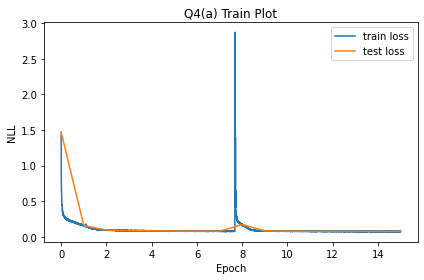

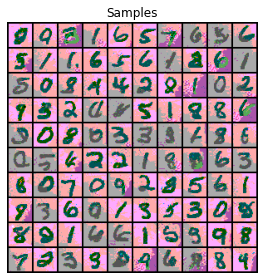

In [ ]:
q4a_save_results(q4_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# For debugging purpose

# import numpy as np

# data_dir = get_data_dir(1)
# train_data, test_data = load_pickled_data(join(data_dir, 'mnist_colored.pkl'))
# image_shape = (28, 28, 3)
# H, W, C = image_shape
# train_data = np.transpose(train_data, (0, 3, 1, 2))
# test_data = np.transpose(test_data, (0, 3, 1, 2))
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
def to_binary(x):
    x = x.float()
    x = 0.3 * x[:, [0], :, :] + 0.59 * x[:, [1], :, :] + 0.11 * x[:, [2], :, :]
    x /= 3
    x = (x > 0.5).float()
    return x

class GrayscalePixelCNN(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        C, H, W = input_shape
        self.binary_pixelcnn = PixelCNN((1, H, W), 2, n_filters=64, n_layers=8)
        self.color_pixelcnn = PixelCNN(
            (C, H, W), 4, n_filters=120, n_layers=5, conditional_size=(64, H, W), color_conditioning=True
        )

    def forward(self, x):
        binary = to_binary(x)
        return self.binary_pixelcnn(binary), self.color_pixelcnn(x, cond=binary)

    def loss(self, x):
        binary = to_binary(x)
        return 0.5 * (self.binary_pixelcnn.loss(binary) + self.color_pixelcnn.loss(x, cond=binary))

    def sample(self, n):
        binary = self.binary_pixelcnn.sample(n)
        binary_tensor = torch.from_numpy(binary).permute(0, 3, 1, 2).to(device)
        color = self.color_pixelcnn.sample(n, cond=binary_tensor)
        return binary, color

# For debugging purpose

# model = GrayscalePixelCNN((C, H, W)).to(device)

# for x in train_loader:
#     print(x.shape)
#     out1, out2 = model(x.float().to(device))
#     print(out1.shape, out2.shape)
#     print(model.loss(x.float().to(device)).item())
#     break

# binary, color = model.sample(2)
# print(binary.shape, color.shape)

In [ ]:
def q4_b(train_data, test_data, image_shape):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
    - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
    """
    # You will need to generate the binary image dataset from train_data and test_data
    
    """ YOUR CODE HERE """
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

    H, W, C = image_shape
    model = GrayscalePixelCNN((C, H, W)).to(device)

    train_losses, test_losses = train(
        model, train_loader, test_loader, dict(num_epochs=15, lr=5e-4, grad_clip=1), print_every=1
    )
    binary_samples, color_samples = model.sample(50)

    return train_losses, test_losses, binary_samples, color_samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



Epoch 0, test loss 0.1375, time elapsed 8.146 min
Epoch 1, test loss 0.0766, time elapsed 16.117 min
Epoch 2, test loss 0.0616, time elapsed 24.104 min
Epoch 3, test loss 0.0569, time elapsed 32.115 min
Epoch 4, test loss 0.0543, time elapsed 40.142 min
Epoch 5, test loss 0.0531, time elapsed 48.176 min
Epoch 6, test loss 0.0516, time elapsed 56.202 min
Epoch 7, test loss 0.0506, time elapsed 64.227 min
Epoch 8, test loss 0.1134, time elapsed 72.212 min
Epoch 9, test loss 0.0493, time elapsed 80.193 min
Epoch 10, test loss 0.0485, time elapsed 88.195 min
Epoch 11, test loss 0.0478, time elapsed 96.194 min
Epoch 12, test loss 0.0476, time elapsed 104.194 min
Epoch 13, test loss 0.0470, time elapsed 112.173 min
Epoch 14, test loss 0.0466, time elapsed 120.147 min
Final Test Loss: 0.0466


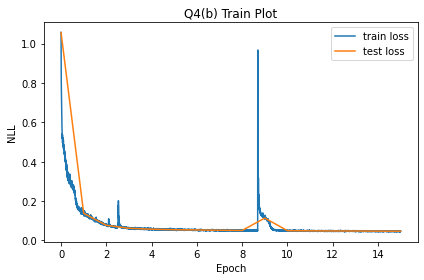

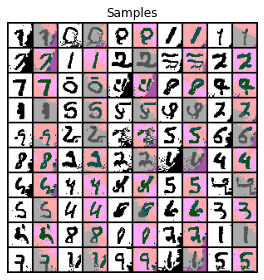

CPU times: user 1h 15min 15s, sys: 48min 29s, total: 2h 3min 45s
Wall time: 2h 3min 54s


In [ ]:
%%time
q4b_save_results(q4_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# For debugging purpose

import numpy as np

data_dir = get_data_dir(1)
train_data, test_data = load_pickled_data(join(data_dir, 'mnist.pkl'))
image_shape = (28, 28, 1)
H, W, C = image_shape
train_data = torch.FloatTensor(train_data).permute(0, 3, 1, 2)
test_data = torch.FloatTensor(test_data).permute(0, 3, 1, 2)
train_data = F.interpolate(train_data, scale_factor=2, mode='bilinear')
test_data = F.interpolate(test_data, scale_factor=2, mode='bilinear')
train_data, test_data = (train_data > 0.5).numpy().astype('uint8'), (test_data > 0.5).numpy().astype('uint8')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, n_filters=64, kernel_size=7, n_layers=4):
        super().__init__()
        model = []
        h_prev = in_channels
        for h in [n_filters] * (n_layers - 1) + [out_channels]:
            model.append(nn.Conv2d(h_prev, h, kernel_size=kernel_size, padding=kernel_size // 2))
            model.append(nn.ReLU())
            h_prev = h
        model.pop()
        self.net = nn.Sequential(*model)
    
    def forward(self, x):
        return self.net(x)

class ParalletPixelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_pixelcnn = PixelCNN((1, 7, 7), n_colors=2, kernel_size=3, n_layers=7)
        self.group_nets = nn.ModuleList([
            CNN(1, 1, n_filters=64, kernel_size=7, n_layers=4),
            CNN(2, 1, n_filters=64, kernel_size=7, n_layers=4),
            CNN(3, 1, n_filters=64, kernel_size=7, n_layers=4),
        ])
        self.base_size = 7
        self.input_shape = (1, 56, 56)

    def loss(self, x):
        x = x.float()
        nll = 0
        n_scale_iters = int(np.ceil(np.log2(x.shape[2] // self.base_size)))
        for i in range(n_scale_iters):
            stride = 1 << (n_scale_iters - i)
            offset = stride // 2
            curr_x = x[:, :, ::stride, ::stride]
            if i == 0:
                nll += (self.base_pixelcnn.loss(curr_x) * self.base_size * self.base_size)
            for j in range(3):
                if j == 0:
                    target = x[:, :, ::stride, offset::stride]
                elif j == 1:
                    target = x[:, :, offset::stride, ::stride]
                else:
                    target = x[:, :, offset::stride, offset::stride]
                logits = self.group_nets[j](curr_x)
                nll += (F.binary_cross_entropy_with_logits(logits, target) * target.shape[-1] * target.shape[-2])
                curr_x = torch.cat((curr_x, target), dim=1)
        return nll / (x.shape[-1] * x.shape[-2])

    def sample(self, n):
        with torch.no_grad():
            samples = torch.zeros(n, *self.input_shape).to(device)
            n_scale_iters = int(np.ceil(np.log2(x.shape[2] // self.base_size)))
            for i in range(n_scale_iters):
                stride = 1 << (n_scale_iters - i)
                offset = stride // 2
                if i == 0:
                    base = self.base_pixelcnn.sample(n)
                    base = torch.from_numpy(base).permute(0, 3, 1, 2).to(device)
                    samples[:, :, ::stride, ::stride] = base
                curr_x = samples[:, :, ::stride, ::stride]
                for j in range(3):
                    probs = torch.sigmoid(self.group_nets[j](curr_x))
                    s = torch.bernoulli(probs)
                    curr_x = torch.cat((curr_x, s), dim=1)
                    if j == 0:
                        samples[:, :, ::stride, offset::stride] = s
                    elif j == 1:
                        samples[:, :, offset::stride, ::stride] = s
                    else:
                        samples[:, :, offset::stride, offset::stride] = s
            return samples.permute(0, 2, 3, 1).cpu().numpy()

# For debugging purpose

# model = ParalletPixelCNN().to(device)

# for x in train_loader:
#     print(x.shape)
#     print(model.loss(x.float().to(device)).item())
#     break

# samples = model.sample(2)
# print(samples.shape)

In [ ]:
def q4_c(train_data, test_data):
    """
    train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
    test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
    image_shape: (H, W), height and width

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
    """
    
    """ YOUR CODE HERE """
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

    model = ParalletPixelCNN().to(device)

    train_losses, test_losses = train(
        model, train_loader, test_loader, dict(num_epochs=20, lr=5e-4, grad_clip=1), print_every=1
    )
    samples = model.sample(100)

    return train_losses, test_losses, samples

### Results

Once you've implemented `q4_c`, execute the cells below to visualize and save your results



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch 0, test loss 0.0294, time elapsed 2.651 min
Epoch 1, test loss 0.0261, time elapsed 5.152 min
Epoch 2, test loss 0.0242, time elapsed 7.654 min
Epoch 3, test loss 0.0231, time elapsed 10.159 min
Epoch 4, test loss 0.0225, time elapsed 12.662 min
Epoch 5, test loss 0.0219, time elapsed 15.162 min
Epoch 6, test loss 0.0216, time elapsed 17.660 min
Epoch 7, test loss 0.0214, time elapsed 20.161 min
Epoch 8, test loss 0.0211, time elapsed 22.657 min
Epoch 9, test loss 0.0209, time elapsed 25.153 min
Epoch 10, test loss 0.0208, time elapsed 27.651 min
Epoch 11, test loss 0.0208, time elapsed 30.147 min
Epoch 12, test loss 0.0206, time elapsed 32.644 min
Epoch 13, test loss 0.0206, time elapsed 35.136 min
Epoch 14, test loss 0.0205, time elapsed 37.630 min
Epoch 15, test loss 0.0204, time elapsed 40.123 min
Epoch 16, test loss 0.0204, time elapsed 42.615 min
Epoch 17, test loss 0.0203, time elapsed 45.110 min
Epoch 18, test loss 0.0203, time elapsed 47.605 min
Epoch 19, test loss 0.020

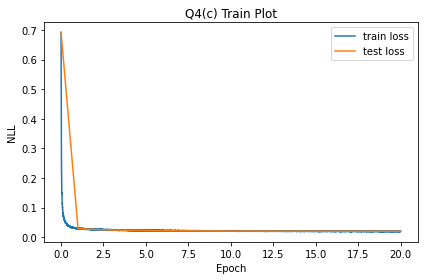

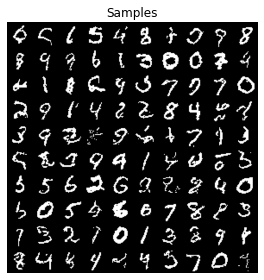

CPU times: user 30min 36s, sys: 19min 30s, total: 50min 7s
Wall time: 50min 11s


In [ ]:
%%time
q4c_save_results(q4_c)